## Named Entity Recognition using Bidirectional LSTMs with POS Tags

In this notebook we extend our bidirectional LSTM model for Named Entity Recognition using POS tags. The model incorporated the POS tags and performs better.

Dataset from Kaggle: https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus

Source website: https://www.depends-on-the-definition.com/introduction-named-entity-recognition-python/

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv("ner_dataset.csv", encoding="latin1")

In [4]:
data = data.fillna(method="ffill")

In [5]:
data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [ ]:
words = data["Word"].unique().tolist()
words

In [7]:
words.append("ENDPAD")
words[-1]

'ENDPAD'

In [8]:
print(len(data["Word"].values))


1048575


In [9]:
n_words = len(words); n_words

35179

In [10]:
tags = data["Tag"].unique().tolist()

In [11]:
n_tags = len(tags); n_tags

17

In [12]:
pos_tags = data["POS"].unique().tolist()

In [13]:
n_pos_tags = len(pos_tags); n_pos_tags

42

So we have 47959 sentences containing 35178 different words with 17 different tags. We use the SentenceGetter class from last post to retrieve sentences with their labels.

In [14]:
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [15]:
getter = SentenceGetter(data)

In [16]:
getter.grouped

Sentence #
Sentence: 1        [(Thousands, NNS, O), (of, IN, O), (demonstrat...
Sentence: 10       [(Iranian, JJ, B-gpe), (officials, NNS, O), (s...
Sentence: 100      [(Helicopter, NN, O), (gunships, NNS, O), (Sat...
Sentence: 1000     [(They, PRP, O), (left, VBD, O), (after, IN, O...
Sentence: 10000    [(U.N., NNP, B-geo), (relief, NN, O), (coordin...
                                         ...                        
Sentence: 9995     [(Opposition, NNP, O), (leader, NN, O), (Mir, ...
Sentence: 9996     [(On, IN, O), (Thursday, NNP, B-tim), (,, ,, O...
Sentence: 9997     [(Following, VBG, O), (Iran, NNP, B-geo), ('s,...
Sentence: 9998     [(Since, IN, O), (then, RB, O), (,, ,, O), (au...
Sentence: 9999     [(The, DT, O), (United, NNP, B-org), (Nations,...
Length: 47959, dtype: object

In [17]:
sent = getter.get_next()
sent

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [83]:
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [18]:
sentences = getter.sentences
sentences

[[('Thousands', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('demonstrators', 'NNS', 'O'),
  ('have', 'VBP', 'O'),
  ('marched', 'VBN', 'O'),
  ('through', 'IN', 'O'),
  ('London', 'NNP', 'B-geo'),
  ('to', 'TO', 'O'),
  ('protest', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('war', 'NN', 'O'),
  ('in', 'IN', 'O'),
  ('Iraq', 'NNP', 'B-geo'),
  ('and', 'CC', 'O'),
  ('demand', 'VB', 'O'),
  ('the', 'DT', 'O'),
  ('withdrawal', 'NN', 'O'),
  ('of', 'IN', 'O'),
  ('British', 'JJ', 'B-gpe'),
  ('troops', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('that', 'DT', 'O'),
  ('country', 'NN', 'O'),
  ('.', '.', 'O')],
 [('Iranian', 'JJ', 'B-gpe'),
  ('officials', 'NNS', 'O'),
  ('say', 'VBP', 'O'),
  ('they', 'PRP', 'O'),
  ('expect', 'VBP', 'O'),
  ('to', 'TO', 'O'),
  ('get', 'VB', 'O'),
  ('access', 'NN', 'O'),
  ('to', 'TO', 'O'),
  ('sealed', 'JJ', 'O'),
  ('sensitive', 'JJ', 'O'),
  ('parts', 'NNS', 'O'),
  ('of', 'IN', 'O'),
  ('the', 'DT', 'O'),
  ('plant', 'NN', 'O'),
  ('Wednesday', 'NNP', 'B-tim'),
  ('

In [19]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

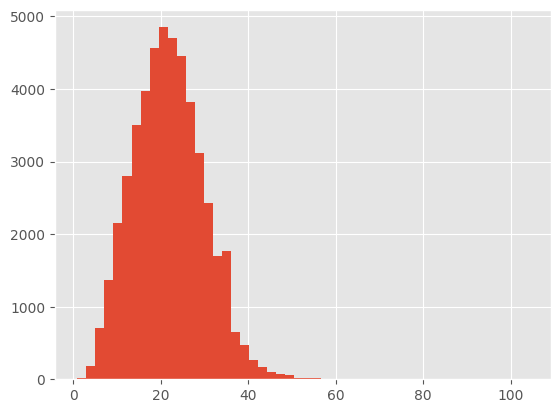

In [20]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

For the use of neural nets (at least with keras, this is no theoretical reason) we need to use equal-lenght input sequences. So we are going to pad our sentences to a length of 50. But first we need dictionaries of words and tags.

In [21]:
max_len = 50
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
pos2idx = {p: i for i, p in enumerate(pos_tags)}

In [ ]:
word2idx

In [90]:
word2idx["Obama"]

2194

In [ ]:
tag2idx

In [91]:
tag2idx["B-geo"]

1

In [94]:
pos2idx["NNS"]

0

Now we map the senctences to a sequence of numbers and then pad the sequence.

In [23]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  9,
  15,
  1,
  16,
  17,
  18,
  19,
  20,
  21],
 [124,
  125,
  126,
  127,
  128,
  7,
  129,
  130,
  7,
  131,
  132,
  118,
  1,
  9,
  123,
  107,
  93,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  21],
 [942,
  943,
  363,
  944,
  344,
  945,
  11,
  9,
  946,
  248,
  200,
  93,
  251,
  317,
  947,
  193,
  180,
  948,
  7,
  3,
  332,
  7,
  949,
  134,
  376,
  305,
  311,
  11,
  950,
  543,
  544,
  21],
 [42, 846, 133, 45, 4645, 4646, 4647, 31, 1878, 352, 21],
 [154,
  836,
  1188,
  7563,
  9398,
  172,
  350,
  93,
  149,
  93,
  840,
  13,
  705,
  305,
  828,
  180,
  16289,
  243,
  1540,
  13,
  2475,
  7,
  2333,
  3778,
  1,
  813,
  4068,
  337,
  19,
  3541,
  12201,
  517,
  273,
  2602,
  21],
 [816,
  9398,
  172,
  9,
  1077,
  7441,
  1209,
  3738,
  254,
  324,
  180,
  11,
  758,
  1,
  1540,
  3787,
  250,
  31,
  9,
  758,
  16290,
  11,
  862,
  93,
  1544,
  154

In [24]:
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words - 1)
X[1]

array([  124,   125,   126,   127,   128,     7,   129,   130,     7,
         131,   132,   118,     1,     9,   123,   107,    93,   133,
         134,   135,   136,   137,   138,   139,    21, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178, 35178,
       35178, 35178, 35178, 35178, 35178], dtype=int32)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
X_pos = [[pos2idx[w[1]] for w in s] for s in sentences]
X_pos

In [29]:
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, padding="post", value=0)
X_pos[1]

array([10,  0,  2, 16,  2,  5,  6,  8,  5, 10, 10,  0,  1,  7,  8,  4, 21,
        1,  7,  4,  8,  8, 17, 19, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [30]:
y = [[tag2idx[w[2]] for w in s] for s in sentences]

In [31]:
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y[1]

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 5, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [32]:
from keras.utils import to_categorical

For training the network we also need to change the labels y to categorial.

In [33]:
y = [to_categorical(i, num_classes=n_tags) for i in y]


In [ ]:
y[1]

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)

Now we can fit a LSTM network with an embedding layer. Note that we used the functional API of keras here, as it is more suitable for complicated architectures.

In [39]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Embedding, concatenate, Dense, TimeDistributed, Dropout, Bidirectional, Input


In [40]:
word_input = Input(shape=(max_len,))
word_emb = Embedding(input_dim=n_words, output_dim=50, input_length=max_len, mask_zero=True)(word_input)

pos_input = Input(shape=(max_len,))
pos_emb = Embedding(input_dim=n_pos_tags+2, output_dim=50,
                    input_length=max_len, mask_zero=True)(pos_input)

model = concatenate([word_emb, pos_emb])
model = Dropout(0.5)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.5))(model)

out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer

In [41]:
model = Model([word_input, pos_input], out)

In [42]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
y_tr

In [44]:
y_tr = np.array(y_tr)

X_pos_tr = np.array(X_pos_tr)


history = model.fit([X_tr,X_pos_tr], y_tr, batch_size=32, epochs=5, validation_split=0.1, verbose=1)


Epoch 1/5
945/945 [==============================] - 269s 274ms/step - loss: 0.3634 - accuracy: 0.9043 - val_loss: 0.1948 - val_accuracy: 0.9462
Epoch 2/5
945/945 [==============================] - 236s 250ms/step - loss: 0.1715 - accuracy: 0.9520 - val_loss: 0.1490 - val_accuracy: 0.9547
Epoch 3/5
945/945 [==============================] - 230s 244ms/step - loss: 0.1402 - accuracy: 0.9599 - val_loss: 0.1314 - val_accuracy: 0.9610
Epoch 4/5
945/945 [==============================] - 227s 240ms/step - loss: 0.1268 - accuracy: 0.9634 - val_loss: 0.1285 - val_accuracy: 0.9627
Epoch 5/5
945/945 [==============================] - 228s 241ms/step - loss: 0.1182 - accuracy: 0.9658 - val_loss: 0.1186 - val_accuracy: 0.9649


In [47]:
hist = pd.DataFrame(history.history)
hist

,loss,accuracy,val_loss,val_accuracy
0,0.363373,0.904255,0.194830,0.946169
1,0.171487,0.952014,0.148985,0.954748
2,0.140190,0.959908,0.131360,0.961041
3,0.126774,0.963353,0.128504,0.962747
4,0.118202,0.965770,0.118558,0.964870


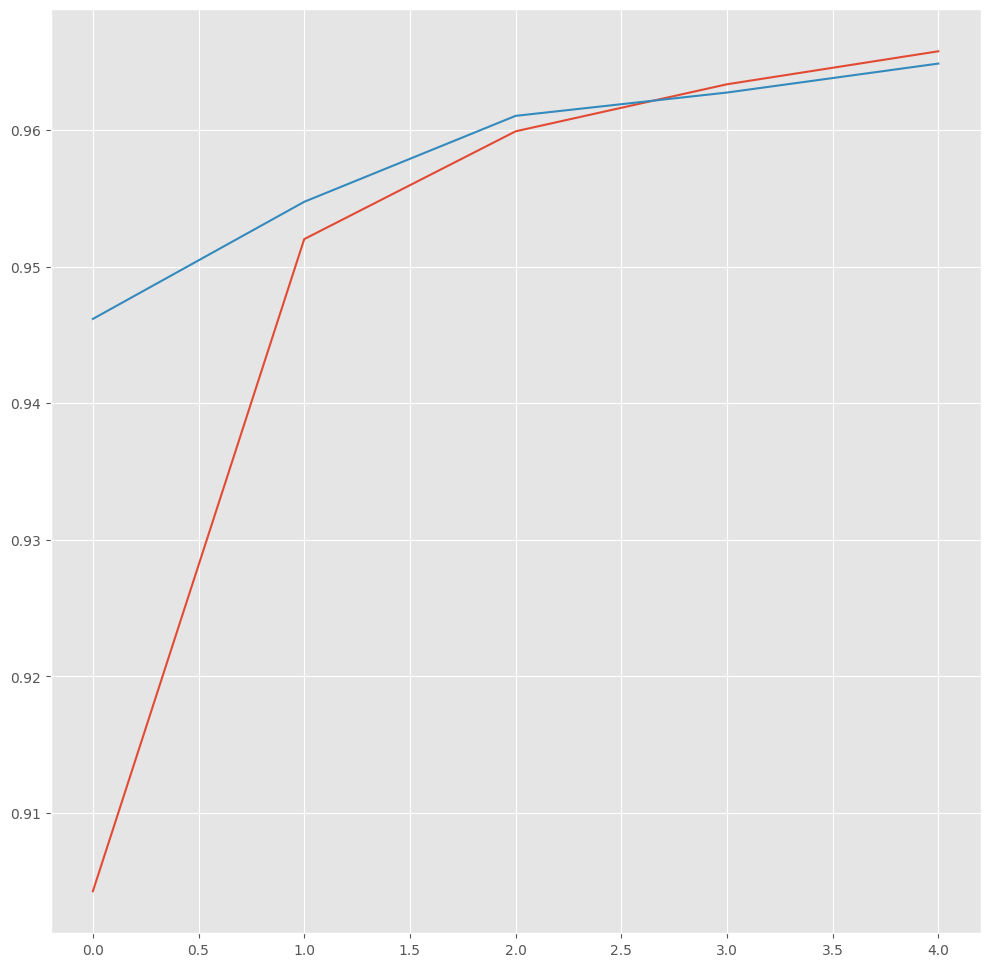

In [50]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.show()

Now let us look at some predictions.

In [51]:
i = 1000
pred = model.predict([X_te, X_pos_te])
#print(pred[i])
p = np.argmax(pred[i], axis=-1)
true = np.argmax(y_te[i], -1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, t, pred in zip(X_te[i], true, p):
    print("{:15}: {:5} {}".format(words[w], tags[t], tags[pred]))

450/450 [==============================] - 21s 44ms/step
Word            (True ): Pred
The            : O     O
US             : B-org B-org
Government     : I-org O
is             : O     O
also           : O     O
a              : O     O
major          : O     O
revenue        : O     O
source         : O     O
for            : O     O
Tuvalu         : B-org B-org
because        : O     O
of             : O     O
payments       : O     O
from           : O     O
a              : O     O
1988           : B-tim B-tim
treaty         : O     O
on             : O     O
fisheries      : O     O
.              : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
ENDPAD         : O     O
E

In [55]:
 import os

 model.save_weights("NER using LSTM-2(100 units)")

In [54]:

# import pickle

# filename = "saved files/NER using LSTM-2(100 units) HISTORY.hdf5"
# pickle.dump(hist, open(filename, 'wb'))